In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [2]:
data = pd.read_csv('energy_consumption_dataset.csv', parse_dates=['Date'])

In [3]:
data.head()

,Date,Energy Consumption
0,2020-01-01,305.311409
1,2020-01-02,299.374329
2,2020-01-03,307.646359
3,2020-01-04,316.811967
4,2020-01-05,299.651923


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1460 non-null   datetime64[ns]
 1   Energy Consumption  1460 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.9 KB


In [5]:
data.describe()

,Date,Energy Consumption
count,1460,1460.000000
mean,2021-12-30 12:00:00.000000256,350.451726
min,2020-01-01 00:00:00,265.886301
25%,2020-12-30 18:00:00,324.913290
50%,2021-12-30 12:00:00,349.962555
75%,2022-12-30 06:00:00,375.550666
max,2023-12-30 00:00:00,424.172656
std,NaN,31.566215


In [6]:
# Extract day, month, and year from the Date column
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data.drop('Date', axis=1)

,Energy Consumption,Day,Month,Year
0,305.311409,1,1,2020
1,299.374329,2,1,2020
2,307.646359,3,1,2020
3,316.811967,4,1,2020
4,299.651923,5,1,2020
...,...,...,...,...
1455,380.398916,26,12,2023
1456,405.951747,27,12,2023
1457,402.642110,28,12,2023
1458,412.140555,29,12,2023


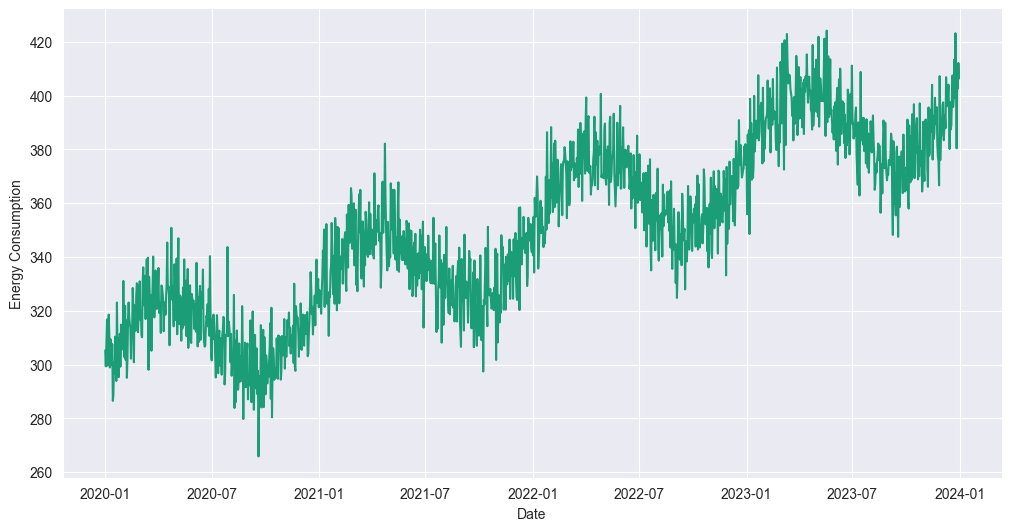

In [7]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Energy Consumption']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Energy Consumption')

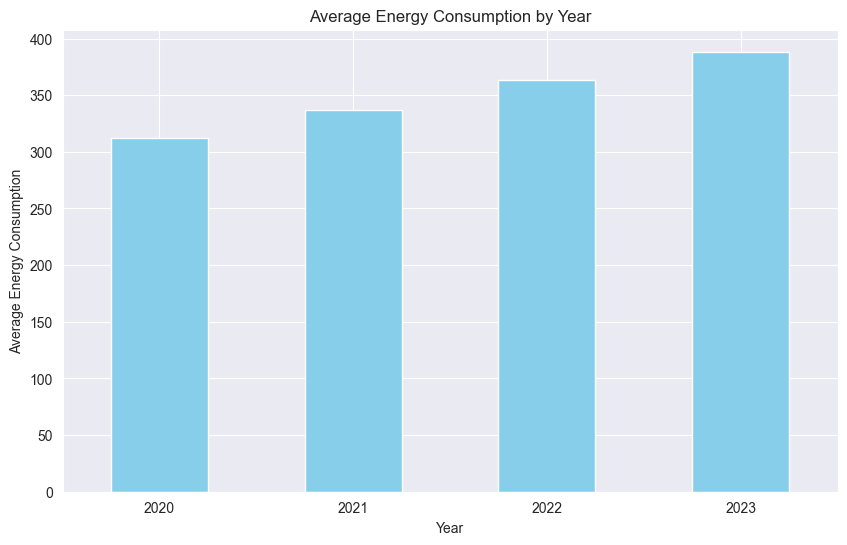

In [8]:
# Group by Year and calculate the average energy consumption
Year_avg_consumption = data.groupby('Year')['Energy Consumption'].mean()
# Optionally, plot the Year average energy consumption
plt.figure(figsize=(10,6))
Year_avg_consumption.plot(kind='bar', color='skyblue')
plt.title('Average Energy Consumption by Year')
plt.xlabel('Year')
plt.ylabel('Average Energy Consumption')
plt.xticks(rotation=0)
plt.show()

# Pretraitement

In [9]:
# Convert all columns to numeric, forcing any errors to be handled
data = data.apply(pd.to_numeric, errors='coerce')

# Drop any remaining rows with NaN values (if any conversion errors happened)
data = data.dropna()

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['Energy Consumption'] = scaler.fit_transform(data['Energy Consumption'].values.reshape(-1, 1))

In [11]:
data

,Date,Energy Consumption,Day,Month,Year
0,1577836800000000000,0.249075,1,1,2020
1,1577923200000000000,0.211566,2,1,2020
2,1578009600000000000,0.263826,3,1,2020
3,1578096000000000000,0.321731,4,1,2020
4,1578182400000000000,0.213320,5,1,2020
...,...,...,...,...,...
1455,1703548800000000000,0.723452,26,12,2023
1456,1703635200000000000,0.884886,27,12,2023
1457,1703721600000000000,0.863977,28,12,2023
1458,1703808000000000000,0.923985,29,12,2023


# CNN Model

In [12]:
# Split the data into features and labels
X = data.drop('Energy Consumption', axis=1).values
X = data.drop('Date', axis=1).values
y = data['Energy Consumption'].values

In [13]:
X

array([[2.49074583e-01, 1.00000000e+00, 1.00000000e+00, 2.02000000e+03],
       [2.11566111e-01, 2.00000000e+00, 1.00000000e+00, 2.02000000e+03],
       [2.63826014e-01, 3.00000000e+00, 1.00000000e+00, 2.02000000e+03],
       ...,
       [8.63977247e-01, 2.80000000e+01, 1.20000000e+01, 2.02300000e+03],
       [9.23985229e-01, 2.90000000e+01, 1.20000000e+01, 2.02300000e+03],
       [8.87639653e-01, 3.00000000e+01, 1.20000000e+01, 2.02300000e+03]])

In [14]:
# Reshape the data for 1D CNN input
X = np.expand_dims(X, axis=2)

In [17]:
# Define the 1D CNN model with padding
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='linear'))

/Users/marouandgh/IdeaProjects/Deep_learning/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
from tensorflow.keras.metrics import MeanAbsoluteError
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])
# Compile and train the model with validation split
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 467.8958 - mean_absolute_error: 16.5862 - val_loss: 2.3599 - val_mean_absolute_error: 1.5338
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7977 - mean_absolute_error: 2.0517 - val_loss: 0.0206 - val_mean_absolute_error: 0.1199
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1690 - mean_absolute_error: 0.3440 - val_loss: 0.0282 - val_mean_absolute_error: 0.1466
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409 - mean_absolute_error: 0.1632 - val_loss: 0.1285 - val_mean_absolute_error: 0.3474
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - mean_absolute_error: 0.1502 - val_loss: 0.0587 - val_mean_absolute_error: 0.2260
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 - mean_absolute_error: 0.1493 - val_loss: 0.1054 - val_mean_absolute_error: 0.3125
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311 - mean_absolute_error: 0.1464 - val_loss: 0.

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

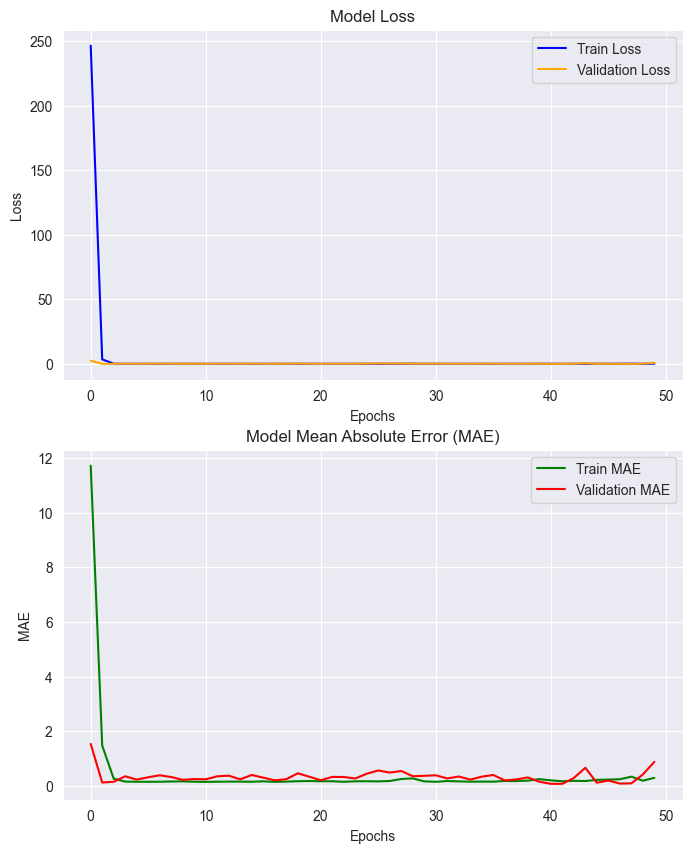

In [24]:
# Create a figure with two subplots for separate diagrams
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot loss
ax1.plot(history.history['loss'], label='Train Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

# Plot MAE
ax2.plot(history.history['mean_absolute_error'], label='Train MAE', color='green')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='red')
ax2.set_title('Model Mean Absolute Error (MAE)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout